# A Big Dam Problem:
# Identifying critical landscapes around the globe that will be affected by future dam construction.
Contributors: Lauren Herwehe, University of Colorado, Boulder and Stephanie L. Shepherd, Auburn University

## We should give a dam

Since the early 20th Century the majority of major rivers around the globe have been impounded or diverted to harness the power of water for energy production, transportation, flood control, water storage, and recreation (2, 3). Although society benefits greatly from dams, they come at an often significant cost to ecosystems.

Dams have dramatic impacts both upstream and downstream. Upstream they slow water flow, trapping sediment, fish, and water, hurting river and wetland habitats. Downstream they can dry out entire landscapes and disrupt annual cycles of flooding that supply sediment and nutrients that are critical to ecosystem health. This kills plants and animals and alters aesthetics of beautiful landscapes (4). Thousands of new dams are proposed globally that will potential impact protected areas such as National Parks, UNESCO World Heritage Sites, and UN Designated Ramsar Wetland Sites adjacent to rivers.

This project is a collaboration with the World Wildlife Foundation (WWF) to identify critical habitats around the world that will be impacted by future dam construction. It builds off of the WWF's <a href="https://www.nature.com/articles/s41586-019-1379-9"> published dataset and research</a> on Free Flowing Rivers.

<img src="https://e360.yale.edu/assets/site/_1500x1500_fit_center-center_80/GettyImages-629283638_web.jpg"
     alt="Niger river"
     width="1000" height="700" 
     style="float: left; margin-right: 5px;"/>

Image: Locals gather near a dam on the Ngadda River in northern Nigeria. Source: <a href="https://e360.yale.edu/assets/site/_1500x1500_fit_center-center_80/GettyImages-629283638_web.jpg>"> Getty Images</a>

## Asking the right question
The question we aimed to answer in our project was: What is the impact of proposed dams on protected areas globally?

We worked to answer this by making two calculations for every country in the world---the **total length of rivers** on protected lands affected by proposed dams and the **total area of protected lands** affected by proposed dams.

## Finding the data
Various organizations and researchers have gathered information about global rivers that we have leveraged to answer this. We used three datasets, one for rivers and two for protected areas:

**River & Proposed Dam Data**: The <a href="https://figshare.com/articles/Mapping_the_world_s_free-flowing_rivers_data_set_and_technical_documentation/7688801"> Free Flowing Rivers (FFR) database</a> contains summary information for all major rivers across the globe. It includes an attribute called Degree of Regulation (DOR) which is an index of storage volume of reservoirs on a river versus the total annual river flow. It is reported as a percent, where 0% is a free flowing river and 100% is a reach where the flow is completely altered by a dam. The dataset includes both a current DOR value and one accounting for proposed dams (DOR_PLA), and subtracting these two values allowed us to find which rivers have proposed dams.

**Protected Areas**: The <a href="https://www.iucn.org/theme/protected-areas/our-work/quality-and-effectiveness/world-database-protected-areas-wdpa">World Database of Protected Areas (WDPA)</a> is a global database of terrestrial and marine protected areas developed and curated by the International Union for the Conservation of Nature and the United Nations Environmental Programme. We also included <a href="https://www.iucn.org/theme/protected-areas/our-work/quality-and-effectiveness/world-database-protected-areas-wdpa">Ramsar Areas</a> which are wetland areas of critical importance identified under the Convention on Wetlands (1971). 

For context, in Figure 1 below, see protected areas (including both WDPA and Ramsar) and rivers subsetted by degree of regulation.

In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import earthpy as et
import earthpy.plot as ep
import contextily as ctx

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# World Database of Protected Areas - split by continent
et.data.get_data(url="https://ndownloader.figshare.com/files/23354894")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

'C:\\Users\\lherwehe\\earth-analytics\\data\\earthpy-downloads\\continent-country.csv'

In [4]:
# Custon Function
def all_pa_country(wdpa_polys, ramsar_polys, country_name):
    """ This function takes a country name, WDPA polygons, and Ramsar Polygons, and returns a multipolygon feature of 
    the World Database of Protected Areas merged with the ramsar areas for that country.

    Parameters
    ----------
    country_name: str
        Three letter country code for the country to be analyzed.
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected country.
    ramsar_polys: gdf
        The feature with the ramsar polygons for the selected country.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the country.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["PARENT_ISO"] == country_name]
    wdpa_polys = wdpa_polys[wdpa_polys["PARENT_ISO"] == country_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [5]:
# Custon Function
def all_pa_continent(wdpa_polys, ramsar_polys, cont_name):
    """ This function takes WDPA polygons for a continent and global ramsar polygons and returns a multipolygon feature 
    of the World Database of Protected Areas merged with the ramsar areas for that continent.

    Parameters
    ----------
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected continent.
    ramsar_polys: gdf
        The feature with all global ramsar polygons.
    cont_name: str
        The name of the selected continent.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the continent.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["continent"] == cont_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [6]:
# Open continent & country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))

continent_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                               "Continents.shp"))

# Reproject data to World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
country_borders = country_borders.to_crs('epsg:4087')
continent_borders = continent_borders.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [7]:
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

# Reproject ramsar data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
ramsar_polys = ramsar_polys.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [8]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))

In [9]:
# Get all current rivers in selected continent
all_rivers_0to5_africa = dor_0to5[dor_0to5['CONTINENT'] == "Africa"]
all_rivers_5to10_africa = dor_5to10[dor_5to10['CONTINENT'] == "Africa"]
all_rivers_10to15_africa = dor_10to15[dor_10to15['CONTINENT'] == "Africa"]
all_rivers_15to20_africa = dor_15to20[dor_15to20['CONTINENT'] == "Africa"]
all_rivers_over20_africa = dor_over20[dor_over20['CONTINENT'] == "Africa"]

# Get all current rivers in selected country
all_rivers_0to5_nga = dor_0to5[dor_0to5['ISO_NAME'] == "Nigeria"]
all_rivers_5to10_nga = dor_5to10[dor_5to10['ISO_NAME'] == "Nigeria"]
all_rivers_10to15_nga = dor_10to15[dor_10to15['ISO_NAME'] == "Nigeria"]
all_rivers_15to20_nga = dor_15to20[dor_15to20['ISO_NAME'] == "Nigeria"]
all_rivers_over20_nga = dor_over20[dor_over20['ISO_NAME'] == "Nigeria"]

In [10]:
# For loop to (1) calculating difference in DOR between planned and current, (2) pulling only rivers with class > 3,
# (3) projecting rivers, (4) buffer by 1/100 km to become polys for overlay fuction, (5) pull only needed columns

gdf_list = [all_rivers_0to5_africa, all_rivers_5to10_africa, all_rivers_10to15_africa, all_rivers_15to20_africa, all_rivers_over20_africa]

river_list_prj = []

for shp in gdf_list:
    shp['DOR_DIFF'] = shp['DOR_PLA'] - shp['DOR']
    shp = shp[shp.RIV_CLASS >= 3]
    shp = shp.to_crs('epsg:4087')
    shp['geometry'] = shp.buffer(100)
    shp = shp[['LENGTH_KM', 'RIV_ORD', 'RIV_CLASS', 'CONTINENT',
               'ISO_NAME', 'BAS_NAME', 'DOR', 'DOR_PLA', 'DOR_DIFF', 'Shape_Leng', 'geometry']]
    river_list_prj.append(shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

# Concatanate all rivers gdfs for easier analysis later
all_rivers = pd.concat([dor_0to5, dor_5to10, dor_10to15,
                        dor_15to20, dor_over20], axis=0)

# Remove rivers that have DOR_DIFF of 0
all_rivers_lg = all_rivers[all_rivers.DOR_DIFF > 0]

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [11]:
# Analyze Africa
wdpa_africa_polys = gpd.read_file(os.path.join(wd_path,
                                               "earthpy-downloads", "WDPA_Africa", "WDPA_Africa.shp"))

# Data cleaning - remove polygons with no area & take only the needed columns from WDPA dataset
wdpa_africa_polys = wdpa_africa_polys[wdpa_africa_polys.geometry != None]

# Merge continent africames with WDPA data for aafricalyzing by continent
wdpa_africa_polys = pd.merge(wdpa_africa_polys, continent_iso,
                             left_on='PARENT_ISO', right_on='ISO3')

# Take only the columns we need
wdpa_africa_polys = wdpa_africa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'GIS_AREA', 'continent', 'geometry']]

# Reporject WDPA data
wdpa_africa_polys = wdpa_africa_polys.to_crs('epsg:4087')

# Get the combined WDPA & ramsar areas for selected continent
wdpa_ramsar_africa = all_pa_continent(
    wdpa_africa_polys, ramsar_polys, "Africa")

# Getting river length affected
# Overlay current rivers on protected areas for selected continent to get ONLY rivers the overlap PAs
river_overlap_africa = gpd.overlay(
    wdpa_ramsar_africa, all_rivers_lg, how='intersection')

# Getting protected areas affected
# Overlay projected rivers on pas for selected continent to get ONLY pas that overlap rivers
pa_overlap_africa = gpd.overlay(
    river_overlap_africa, wdpa_ramsar_africa, how='intersection')

# Get a list of countries in each continent for calculating lengths/areas by country later
africa_countries = continent_iso[continent_iso.continent == 'Africa']

# Create empty lists
country_sums = []
area_sums = []
countries = []

# Sum up the total river length affected by country in the continent
for country in africa_countries.ISO3:
    country_sums.append((
        river_overlap_africa.loc[river_overlap_africa['PARENT_ISO'] == country, 'LENGTH_KM'].sum()).round(0))
    area_sums.append((
        pa_overlap_africa.loc[pa_overlap_africa['PARENT_ISO_1'] == country, 'Shape_Area_1'].sum()).round(0))
    countries.append(country)

 # Create a pandas dataframe of lengths and areas affected
africa_affected = pd.DataFrame(list(zip(countries, country_sums, area_sums)), columns=[
    'Country', 'Affected_KM', 'Affected_Area'])

africa_affected = africa_affected[africa_affected.Affected_KM != 0]
africa_affected = africa_affected[africa_affected.Affected_Area != 0]

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [12]:
# Get continent border for plotting
africa_border = continent_borders[continent_borders['CONTINENT'] == "Africa"]

# Buffer rivers for nicer map
dor_0to5 = dor_0to5.buffer(5000)
dor_5to10 = dor_5to10.buffer(5000)
dor_10to15 = dor_10to15.buffer(5000)
dor_15to20 = dor_15to20.buffer(5000)
dor_over20 = dor_over20.buffer(5000)

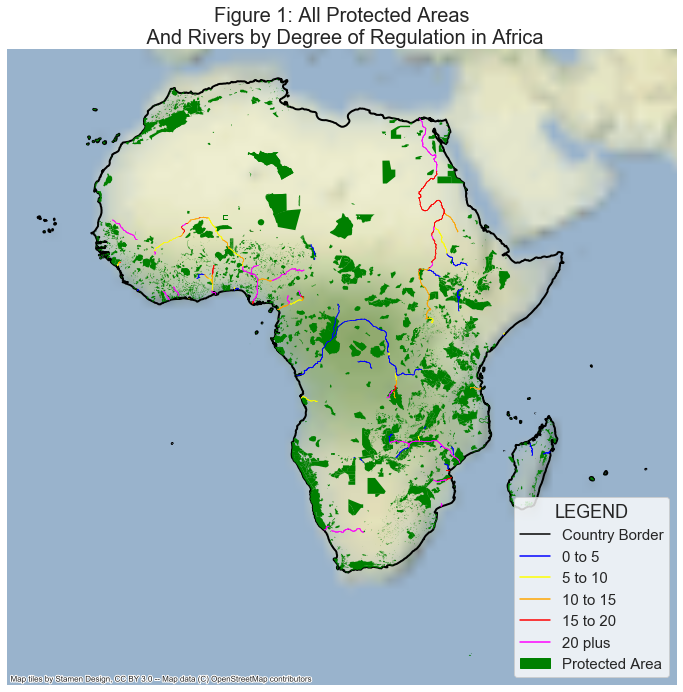

In [23]:
# Plot all rivers and all protected areas for selected continent
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
blue_line = mlines.Line2D([], [], color='blue', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
green_patch = mpatches.Patch(color='green', label='Protected Area')

fig, ax = plt.subplots(figsize=(12, 12))
africa_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
wdpa_ramsar_africa.plot(ax=ax, color="green", edgecolor='none')
dor_0to5.plot(ax=ax,
              color='blue', edgecolor='none')
dor_5to10.plot(ax=ax,
               color='yellow', edgecolor='none')
dor_10to15.plot(ax=ax,
                color='orange', edgecolor='none')
dor_15to20.plot(ax=ax,
                color='red', edgecolor='none')
dor_over20.plot(ax=ax,
                color='magenta', edgecolor='none')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_title(
    'Figure 1: All Protected Areas\n And Large Rivers by Degree of Regulation in Africa', size=20)
ax.set_axis_off()
ax.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, green_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")

## Answering the question with open source GIS

We devised a way to answer our research question with the openly available datasets above and Python. Our step-by-step approach was as follows:
1. **Combine protected areas datasets** - First we created a function that combined the two protected areas datasets: WDPA and Ramsar.
2. **Identify large rivers with proposed dams** - Next we took the FFR dataset and subtracted the current DOR from the planned DOR for all rivers to filter for only rivers with planned dams. We also filtered to only look at large rivers to keep processing time manageable.
3. **Identify where rivers and protected areas intersect** - Then we performed two 'overlays' with the open source GIS package Geopandas: 
    * Overlay rivers on protected areas and return only the **rivers** that intersect protected areas.
    * Do the reverse of above to return only the **protected areas** that are intersected by rivers.
4. **Add it all up** - Finally we summed the above data by country to get the total river length affected by country and the total protected area impacted by country.

Below in Graphs 1 and 2 you will see these results for Africa.


Text(0.5, -0.1, 'World Database of Protected Areas, Ramsar Site Database,\n Free Flowing Rivers')

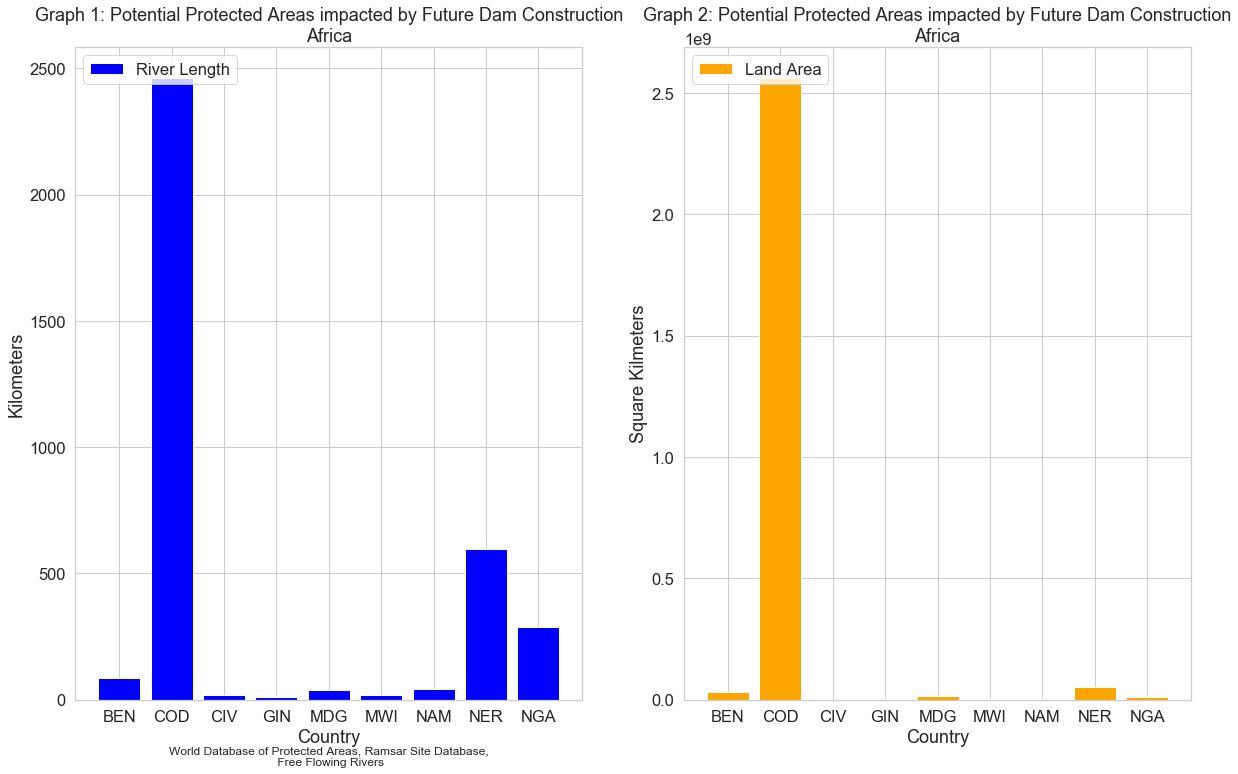

In [24]:
# Create Graph
# use white grid plot background from seaborn
sns.set(font_scale=1.5, style='whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

ax1.bar(africa_affected["Country"],
        africa_affected["Affected_KM"], color='blue', label="River Length")
ax1.legend(loc="upper left")
ax1.set(title="Graph 1: Potential Protected Areas Impacted by Future Dam Construction\nAfrica",
       xlabel="Country", ylabel="Kilometers")

ax2.bar(africa_affected["Country"],
        africa_affected["Affected_Area"], color='orange', label="Land Area")
ax2.legend(loc="upper left")
ax2.set(title="Graph 2: Potential Protected Areas Impacted by Future Dam Construction\nAfrica",
       xlabel="Country", ylabel="Square Kilmeters")
ax1.text(0.5, -0.1,
        "World Database of Protected Areas, Ramsar Site Database,\n Free Flowing Rivers",
        size=12,
        ha="center",
        transform=ax1.transAxes)

## What the data says
At the moment, due to the size of both the protected areas and free flowing rivers datasets, we have analyzed data for Africa, South America, Asia, and Australia and are working to getting results for Europe and North America. From our initial results we are beginning to gain insight on where and to what extent dams are being constructed, and where the potential negative impacts on protected areas are greatest. 

## Future work

xxxx

### For more information about this project, including the full code and data analysis, see the <a href=" https://github.com/stephlshep/global-dam-impacts"> repository on GitHub</a>.

## References
1. Graf, W.L. 2001. Damage Control: Restoring the Physical Integrity of America’s Rivers in The Annals of the Association of American Geographers, 91(1), p. 1-27.
2. Nilsson, C., Reidy, C.A., Dynesius, M., Revenga, C.. 2014. Fragmentation and Flow Regulation of the World’s Large River Systems in Science, 308(5720), p. 405-408. DOI: 10.1126/science.1107887
3. McAllister, D.E., Craig, J.F., Davidson, N., Delany, S., Seddon, M. 2001. Biodiversity Impacts of Large Dams. International Union for Conservation of Nature and Natural Resource and the United Nations Environmental Programme Report. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.392.9398&rep=rep1&type=pdf

## Contact:
Lauren Herwehe, Education Program Manager
Earth Lab
University of Colorado
Boulder, CO
Lauren.Herwehe@colorado.edu

Stephanie L. Shepherd, Assistant Professor
Dept. of Geosciences
Auburn University
Auburn, AL
slshepherd@auburn.edu